In [17]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Looking at the X, y
X.shape, y.shape, X[:10], y[:10]

((3629,),
 (3629,),
 array([37, 19, 18, 19, 31, 27, 16, 37, 19, 18]),
 array([19, 18, 19, 31, 27, 16, 37, 19, 18, 19]))

In [15]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for layer in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = dys.copy()
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            # dXs.append(dX)
            dXs[t] = dX
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [16]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    #for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 100)
            print(sample)

    return nn

Iter-1 loss: 222.6565
 on' In Aves Aeenrthe fs u,satin , b2lysto-tholdsis 1xBanr the Dcie. Jelwekesesexs in the Gnxthed sit
Iter-2 loss: 214.5490
 frest Gin lount fernis d-on And 9ivan o9 wounjes isst renAtyxa, Gmrlst-oulexsted uslting Japanl Asid
Iter-3 loss: 204.0681
 It an tiunt in thevexnerttintarl foxle des As he upth-sarots the noultase f Ctunt eshe the thirosel 


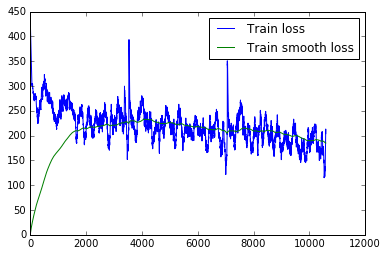

In [14]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 3 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 226.1523
 6o the Japan taxdr band Ho loris thil og bakort0a ssore va3x KhjAod ian te in in rhe rDun -N2xJapand
Iter-2 loss: 204.8859
 2heltire thennur the Cuoprla nloflale iss thesan, no)tG , mibtk or nante mhinse Japan sand Dy Japan 
Iter-3 loss: 209.7551
 NDJapan und doubst rowesty Aumet ogata in the livblo nhe for ts thengumesterxnf cobpire ind bourrlys
Iter-4 loss: 201.3236
 Uanjy Jvpand andtsxl chtob moded Tho bobhe Itatand dended is pemile yound and Uy thi he1s and. Ainat
Iter-5 loss: 198.5959
 malerin the firhe al btettyy (Cginalinity P, the Globelecinctit tumane n ured lountede expentur, sil
Iter-6 loss: 199.5659
 oflled leede 9Fpctend banguwan is the ofat eDentiry cong lowint an seentean pere tho fobelcagelred a
Iter-7 loss: 190.6901
 the niutomensthoul the Globac inste-dexpentriand the live and in the G20melec im the Courch-largest 
Iter-8 loss: 197.2478
 Someleg maea and sumat in the w2r d5inecenes we fled an, West onflied ingal country Wend a dertal-ce
Iter-9 l

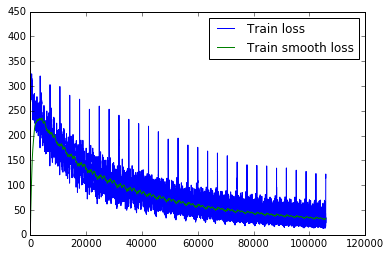

In [4]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 30 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 loss: 224.1500
 miean Wx peanv, Japan CDorthi rith G9mR8ex ond burthe Norof Aipckrinn TnRtsr ripthaPs Gumi, Ro por2 
Iter-2 loss: 204.5220
 coler- lanla yinh chCovexinryark mse wargSunaHd pouaseg ofghethish Gopins andLWs Dexties 90o hi Dovi
Iter-3 loss: 198.6107
 loulaas, the EopsHanth CE's tith the tere ink ine GxAst Glopan Sis, in makry 17, t"ec. Fans checkorl
Iter-4 loss: 183.1245
 8plitered th the Empurtro and A jokeo1f in ean-Honsie OHuns re unfre tarAry wor the fpurt realles th
Iter-5 loss: 175.8622
 haunst Japan wist and Japan, the hist anokeeg, st vopond ry wigh hich wokbl-nofh the Umport cCfertt 
Iter-6 loss: 173.0827
 and of NheRwist rgg ol ziotly with in th- ancexth renoy, Is chilant in the  furth. Tde worstand 9nt 
Iter-7 loss: 174.0925
 miotioncury cosst to islled ts the alopexArsi. Japanas eJpeconala tsest resturyy, whund -Japan es ce
Iter-8 loss: 163.1981
 and Hushaskallofed Sencecternd Wrats imll wrost CIwbont pendivanes. Japanest ralicy forntalced and t
Iter-9 l

Iter-67 loss: 47.7948
 Tokyo and at the serol to of Japane eass a dixth largest military budget, used for seates of interca
Iter-68 loss: 47.9095
 and the world's eighth largest military budget, used fol the Gy, expanchestk muntiry wan Emperor an 
Iter-69 loss: 46.1993
 alest revisoly wan the anded it restre. Dhe up with the Sino, a lorter. Wist rifoliol touthith reake
Iter-70 loss: 46.0350
 propeclin to of 6,852 is and inse nmmel wornalivingist anden the First in the Chunthe G wate in thi 
Iter-71 loss: 44.7931
 and the world's anoresl-Japanese Ware divine a mbextorgest imperim mainly Imperial Cohogh an Emperor
Iter-72 loss: 44.2393
 of cohed Jangr histolited inte in the natioun" and Huthi-d kue,, which came ty in the world, and ran
Iter-73 loss: 43.7388
 popelation op Japan is in oun", and the world's fourth. From the Sea of Okhotsk in the north to the 
Iter-74 loss: 42.6085
 al eletted frletertest imperte cantudisene as Japan has officiacloded eturititat of the Firsh tho wa
Iter-75 

Iter-133 loss: 22.2624
 is largest military budget, used for self-defense and peacekeeping roles. Japan is a developed const
Iter-134 loss: 21.4611
 arokkoun in Chine im the catetityo Nopecand a dien, Sthoca Sin1a a lowed popor the GD und the Eupari
Iter-135 loss: 22.1553
 fourth-largest ixpopiecge tordesty sixth in the Globed Stata and the world's eyurth largest ixpopina
Iter-136 loss: 21.0332
 fourter and fourth-largest importer. Although Japan has officially renounced its right to declare wa
Iter-137 loss: 21.6521
 and the G20ta an Emperor and an elected legislature thilalion in the Courthildet the Global Competit
Iter-138 loss: 20.7309
 as a strat of increasing powar, It il the obing bolttolited cited a untein ladee fourth-largest expo
Iter-139 loss: 21.0231
 foresland mounded in, is and errom inhec aregionsr a olntury CEnfike porld in 1868 borldand in isola
Iter-140 loss: 20.5507
 war 1945 Infeealled the highest million meotent in the number of the UN, the G7, the G8, and the G20


Iter-199 loss: 13.2162
 the world's eighth largest military budget, used for self-defenal cinttion in the First wint enpan e
Iter-200 loss: 13.2400
 arowikat power. The country hasth to the East China Sea and Taiwan in the south. The kanji that make


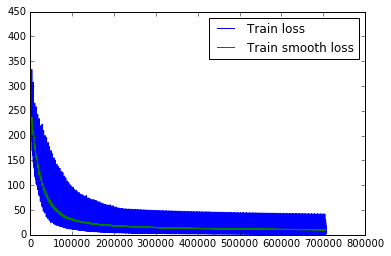

In [4]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 200 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()